In [1]:
from typing import Callable

import checker
import matplotlib.pyplot as plt
import numpy as np
import utils

## Funkcje kosztu
Uczenie maszynowe to dziedzina zajmująca się tworzeniem modeli matematycznych, które ucząc się na podstawie przykładów ze **zbioru treningowego** są w stanie przewidywać rozwiązania na **zbiorze testowym**. Chwilowo skupimy się na uczeniu modelu na zbiorze treningowym - czyli na optymalizacji - natomiast testowanie na zbiorze testowym (generalizację) zbadamy na innych zajęciach.

Jeśli potrafimy określić funkcję, której minimalizacja wiąże się z rozwiązaniem naszego problemu, jest szansa, że metody uczenia maszynowego będą w stanie tę funkcję zminimalizować - i w rezultacie rozwiązać problem. Funkcję, której minimalizacja oznacza rozwiązanie problemu, będziemy nazywać **funkcją kosztu (loss function)**.

W rzeczywistości określenie takich funkcji jest najczęściej dosyć proste:

* Jeśli chcemy zbudować model, który podstawie zdjęcia domu ma określać jego cenę rynkową, funkcją kosztu może być moduł z różnicy posumowany dla całego datasetu: $\sum |\mathrm{prawdziwa\_cena} - \mathrm{cena\_wg\_modelu}|$.
* Jeśli chcemy, żeby nasz model dawał nam prawdopodobieństwo, czy na podanym zdjęciu znajduje się kot czy pies, naszym kosztem może być jakaś miara odległości $d$ pomiędzy rozkładem zadanym przez model a prawdziwym rozkładem: $d(\mathrm{rozklad\_modelu}, \mathrm{rozklad\_prawdziwy})$.
* Kiedy mamy robota, którego celem jest zbieranie, funkcją kosztu może być: $-\mathrm{liczba\_podniesionych\_puszek}$.

Celem pierwszych ćwiczeń jest zapoznanie z ogólną formą funkcji kosztu -- rozwiązywane problemy będą więc na razie dosyć proste. 

## Zbiór treningowy
Jeśli chcemy przewidywać ceny domów na podstawie zdjęcia, będziemy potrzebować zbioru zawierającego zdjęcia i ceny domów. Zbiór danych, na których minimalizujemy funkcję kosztu nazywamy **zbiorem treningowym** (train set).

Na ten moment zbiór treningowy i zadanie do wykonania będzie proste: zadany zbiór danych $X = (x_1, \ldots x_N) \subset \mathbb{R}^D$ należy zareprezentować za pomocą pojedynczego punktu $v \in \mathbb{R}^D$, takiego, który będzie minimalizował zadaną funkcję kosztu.

Zbadamy sytuację dla $D \in {1, 2, 10}$.

In [2]:
# Proszę nie zmieniać seedu, to nam zapewni, ze bedzięmy pracować na tych samych datasetach
np.random.seed(60)

# Pierwszy zbiór wygenerujemy, losując punkty z rozkładu jednostajnego
train_set_1d = np.random.uniform(-5, 5, size=(15, 1))

# Drugi zbiór wygenerujemy, losując punkty z rozkładu normalnego
train_set_2d = np.random.normal(-1, 3, size=(13, 2))

# Trzeci zbiór wygenerujemy, losując punkty z rozkładu wykładniczego
train_set_10d = np.random.exponential(2, size=(31, 10))
print(train_set_10d[:5, 0])

train_sets = [train_set_1d, train_set_2d, train_set_10d]

print("Parę punktów z datasetu jednowymiarowego:\n", train_set_1d[:5])
print("Parę punktów z datasetu dwuwymiarowego:\n", train_set_2d[:5])
print("Parę punktów z datasetu dziesięciowymiarowego:\n", train_set_10d[:3])

shapes = [dataset.shape for dataset in train_sets]
print("Rozmiary naszych datasetów:", *shapes)
# Pierwszy wymiar reprezentuje liczbę przykładów w datasecie
# Drugi wymiar to wymiar pojedynczego przykładu z datasetu

[1.92650794 2.29209159 0.61110025 3.247719   2.8237559 ]
Parę punktów z datasetu jednowymiarowego:
 [[-1.9912667 ]
 [-3.13054184]
 [-1.76817323]
 [ 1.6574957 ]
 [ 0.66970801]]
Parę punktów z datasetu dwuwymiarowego:
 [[-6.53671154 -0.99144149]
 [-0.96583933 -5.57674233]
 [ 3.14309184  3.15486672]
 [-0.54717522 -3.33306574]
 [-2.49814889  1.45508802]]
Parę punktów z datasetu dziesięciowymiarowego:
 [[1.92650794e+00 2.04239361e+00 3.08092423e+00 5.25508663e+00
  3.64143504e+00 6.58350040e+00 1.60976207e+00 5.96230107e-02
  3.09291354e-01 1.27706253e+00]
 [2.29209159e+00 2.33170339e+00 2.58977125e+00 9.09622883e+00
  9.97396514e-01 1.44048016e+00 5.07452038e+00 9.77349522e-01
  1.18453053e+00 1.18764669e+00]
 [6.11100253e-01 5.28521620e+00 1.45147908e+00 2.18205193e+00
  3.57100011e+00 6.84691549e-03 1.74968831e+00 1.33940689e+00
  6.39317013e-01 6.50040435e-01]]
Rozmiary naszych datasetów: (15, 1) (13, 2) (31, 10)


In [3]:
# Sprawdźmy czy datasety wylosowały się z poprawnego seedu.
similar_vals_1d = np.all(
    np.isclose(
        train_set_1d[:5, 0],
        np.array(
            [
                -1.9912666995338126,
                -3.13054183658122,
                -1.7681732303178057,
                1.6574957028830903,
                0.6697080096921333,
            ]
        ),
    )
)

similar_vals_2d = np.all(
    np.isclose(
        train_set_2d[:5, 0],
        np.array([-6.53671154, -0.96583933, 3.14309184, -0.54717522, -2.49814889]),
    )
)

similar_vals_10d = np.all(
    np.isclose(
        train_set_10d[:5, 0], np.array([1.92650794, 2.29209159, 0.61110025, 3.247719, 2.8237559])
    )
)
assert (
    similar_vals_1d and similar_vals_2d and similar_vals_10d
), "Wylosowane wartości są złe! Zgłoś od razu problem prowadzącemu!"

# Zadanie 1 (2 pkt.)
Należy zaimplementować poniższe funkcje kosztu tak, by zadziałały poprawnie dla wszystkich naszych datasetów (a także dla innych datasetów o potencjalnie innych wymiarach).

Na nasz zbiór danych $X$ możemy patrzeć jak na macierz wymiarów $[N, D]$. Dlatego też zakładamy, że wejściami do funkcji będą następujące argumenty:
* X: tablica np.ndarray o wymiarach [N, D]
* v: wektor o wymiarze [D]


Funkcje kosztu do zaimplementowania:
* mean_error(X, v) = $\frac{1}{N} \sum_{i=1}^N \|X_i - v\|_2$
* mean_squared_error(X, v) = $\frac{1}{N} \sum_{i=1}^N  \|X_i - v\|_2^2$
* max_error(X, v) = $\max_i \|X_i - v\|_2$

Zapis $X_i$ oznacza $i$-ty wektor wierszowy w macierzy $X$, za $N$ należy przyjąć liczbę wierszy w podanej macierzy $X$.

**Podpowiedź do numpy:** w powyższych funkcjach nie trzeba ani razu wykorzystać pętli for.

In [4]:
def mean_error(X: np.ndarray, v: np.ndarray) -> np.ndarray:
    ...


def mean_squared_error(X: np.ndarray, v: np.ndarray) -> np.ndarray:
    ...


def max_error(X: np.ndarray, v: np.ndarray) -> np.ndarray:
    ...

In [5]:
# Testy do zadania
checker.check_1_1(mean_error, mean_squared_error, max_error, train_sets)

## Wizualizacja
Spróbujmy zobaczyć, jak nasza funkcja będzie zmieniała się dla różnych $v$.

Bardzo łatwo jest pokazać na wykresie nasze dane, jeśli znajdują się one w 1D. Dane w 2D oraz 3D są nieco mniej czytelne, ale dalej jesteśmy w stanie je zaprezentować. Natomiast przestrzenie wyżej wymiarowe stanowią dla nas problem. Na ten moment będziemy wizualizować tylko dane w 1D oraz 2D.

### Wizualizacja dla zbioru treningowego 1D

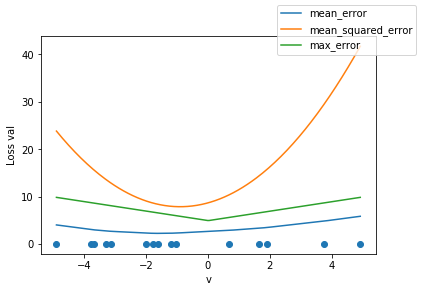

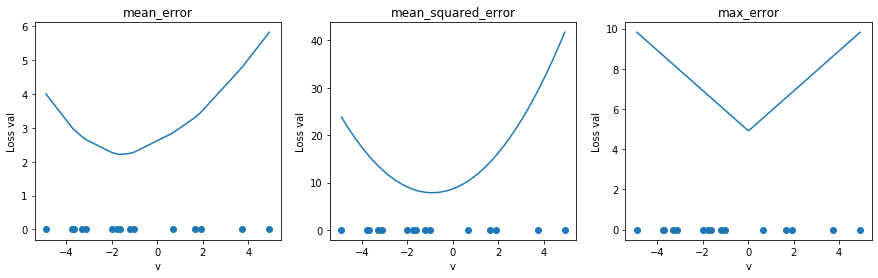

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
utils.plot_1d_set(train_set_1d, ax, [mean_error, mean_squared_error, max_error])
fig.legend()
plt.show(fig)
plt.close(fig)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
utils.plot_1d_set(train_set_1d, axes[0], [mean_error], show_title=True)
utils.plot_1d_set(train_set_1d, axes[1], [mean_squared_error], show_title=True)
utils.plot_1d_set(train_set_1d, axes[2], [max_error], show_title=True)
plt.show(fig)
plt.close(fig)

### Wizualizacja dla zbioru treningowego 2D

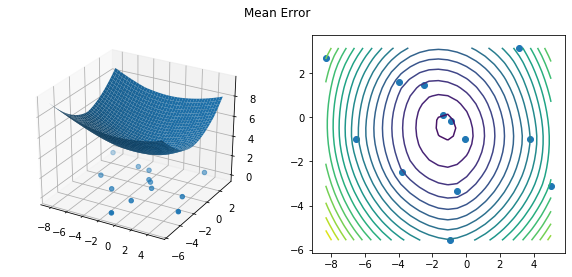

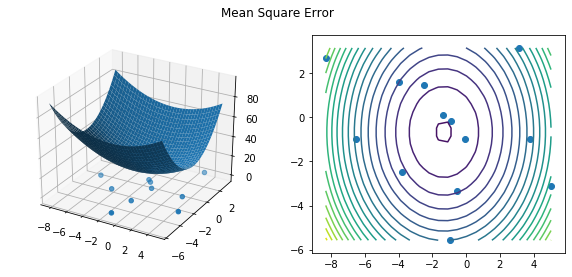

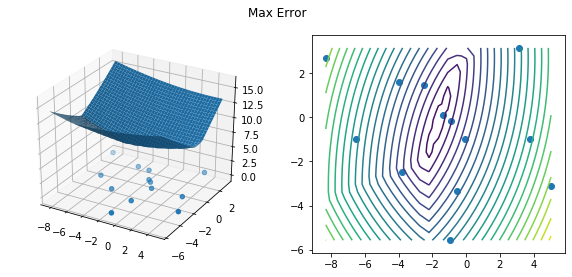

In [7]:
utils.plot_2d_loss_fn(mean_error, "Mean Error", train_set_2d)
utils.plot_2d_loss_fn(mean_squared_error, "Mean Square Error", train_set_2d)
utils.plot_2d_loss_fn(max_error, "Max Error", train_set_2d)

# Zadanie 2 (2 pkt.)
W przypadku jednowymiarowym dla wszystkich zadanych przez nas funkcji kosztu da się znaleźć minimalizujący je punkt $v$, korzystając z prostych wzorów analitycznych.

Na przykład, dla zadanego zbioru $X$, MSE (mean squared error) jest minimalizowane przez liczbę $v = \frac{1}{N} X_i$. Czyli punktem minimalizującym ten koszt jest średnia ze zbioru.

Dla każdej funkcji kosztu z poprzedniego zadania zaimplementuj funkcję, która:
* Na wejściu dostaje macierz X typu np.ndarray o wymiarze $[N, 1]$ 
* Ma zwrócić minimum odpowiedniej funkcji kosztu (skalar), posługując się analitycznym wzorem dla sytuacji jednowymiarowej. Wzory można znaleźć w internecie ;).

In [8]:
def minimize_mse(X: np.ndarray) -> np.ndarray:
    ...


def minimize_me(X: np.ndarray) -> np.ndarray:
    ...


def minimize_max(X: np.ndarray) -> np.ndarray:
    ...

In [9]:
# Testy do zadania
checker.check_1_2(minimize_me, minimize_mse, minimize_max, train_set_1d)

## Wizualizacja minimów i outliery

Przekonajmy się, że na wykresie nasz punkt rzeczywiście będzie w minimum.

Ponadto, zobaczmy co się dzieje z naszymi funkcjami kosztu i ich minimami, kiedy do naszego zbioru dodamy punkt, który wyraźnie odstaje od pozostałych (**outlier**).

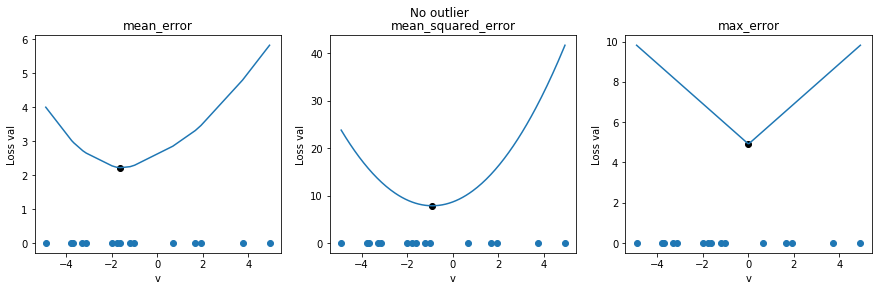

ME minimum: -1.63 MSE minimum: -0.90 Max Error minimum: 0.02


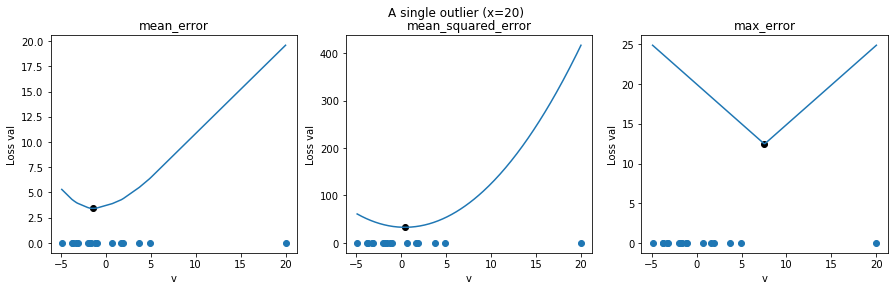

ME minimum: -1.42 MSE minimum: 0.41 Max Error minimum: 7.55


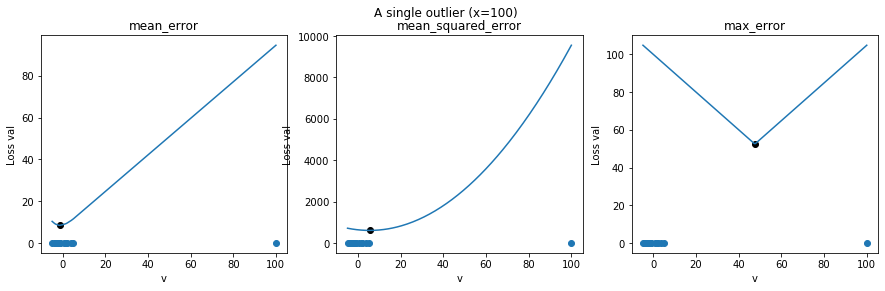

ME minimum: -1.42 MSE minimum: 5.41 Max Error minimum: 47.55


In [10]:
loss_funs = [mean_error, mean_squared_error, max_error]
loss_funs_mins = [minimize_me, minimize_mse, minimize_max]
utils.plot_minimums(train_set_1d, loss_funs, loss_funs_mins, title="No outlier")

small_outlier_dataset = np.append(train_set_1d, 20).reshape(-1, 1)
utils.plot_minimums(
    small_outlier_dataset, loss_funs, loss_funs_mins, title="A single outlier (x=20)"
)

big_outlier_dataset = np.append(train_set_1d, 100).reshape(-1, 1)
utils.plot_minimums(
    big_outlier_dataset, loss_funs, loss_funs_mins, title="A single outlier (x=100)"
)

# Metody gradientowe
Analityczne znalezienie minimów dla podanych funkcji nie jest problemem w 1D - mamy na to zadane wzory. W przypadkach, kiedy $D > 1$, wzór znajdziemy jedynie dla funkcji MSE (będzie to ponownie średnia). Jeżeli chcielibyśmy znaleźć minima pozostałych funkcji z naszego zbioru - a także innych, bardziej skomplikowanych funkcji - musimy wykorzystać inną, bardziej uniwersalną metodę.

W uczeniu maszynowym do optymalizacji funkcji powszechnie stosowana jest metoda spadku gradientu (gradient descent, GD). Zamysł jest prosty - kierunek przeciwny do gradientu funkcji ($-\nabla f(x)$) daje nam kierunek najszybszego spadku tej funkcji. Jeśli zaczniemy od dowolnego punktu i będziemy iteracyjnie podążać w kierunku odwrotnym do gradientu, powinniśmy dotrzeć do jakiegoś minimum. 

Oczywiście są zastrzeżenia:
* nie mamy gwarancji, że dojdziemy do minimum globalnego
* zły wybór długości kroku spowoduje katastrofalne rezultaty
* dla funkcji nieróżniczkowalnych w punktach (takich jak mean error czy maximum error) sytuacja staje się skomplikowana
* wiele, wiele innych.

# Zadanie 3 (2 pkt.) 
Należy zaimplementować gradienty funkcji z poprzedniego zadania (jawne wzory można znaleźć w internecie). Będą nam potrzebne do zaimplementowania metody spadku gradientu.

**UWAGA: Proszę uważać na broadcasting przy dzieleniu wektora przez jego normę. Wtedy może okazać się przydatny argument keepdims.**

In [11]:
def me_grad(X: np.ndarray, v: np.ndarray) -> np.ndarray:
    ...


def mse_grad(X: np.ndarray, v: np.ndarray) -> np.ndarray:
    ...


def max_grad(X: np.ndarray, v: np.ndarray) -> np.ndarray:
    ...

In [12]:
# Testy do zadania
checker.check_1_3(me_grad, mse_grad, max_grad, train_sets)

# Zadanie 4 (2 pkt.)
Implementacja metody spadku gradientu. Zaczynamy od początkowej estymaty, a potem iteracyjnie idziemy coraz bliżej minimum, kierując się gradientami.

W tym zadaniu należy:
* Dokończyć implementację metody spadku gradientu (uzupełnić luki)
* Dla MSE znaleźć najwyższy możliwy learning rate, dla którego metoda spadku gradientu zdoła zbiec do minimum. Należy rozważyć tylko przypadek jednowymiarowy. 

**Pytanie**: dlaczego korzystamy w funkcjach kosztu ze średniej zamiast z sumy po całym zbiorze treningowym?

Text(0.5, 1.0, '1d run, lr=???')

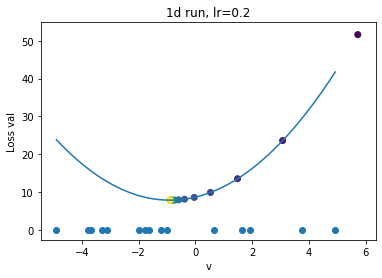

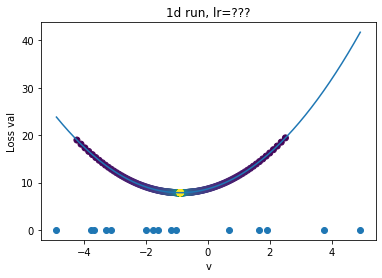

In [13]:
def gradient_descent(
    grad_fn: Callable[[np.ndarray, np.ndarray], np.ndarray],
    dataset: np.ndarray,
    learning_rate: float = 0.2,
    num_steps: int = 100,
):
    """
    grad_fn: funkcja z poprzedniego zadania - przyjmuje dataset
    dataset: zbiór treningowy na którym trenujemy
    learning_rate: prędkość uczenia, określa jak długi krok gradientu mamy robić
    num_steps: liczba kroków metody.
    """
    current_v = np.random.normal(4, size=(dataset.shape[1]))
    all_v = [current_v]

    for step_idx in range(num_steps):
        # liczenie gradientu
        grad = ...  # type: ignore
        # krok metody gradientu
        current_v = ...  # type: ignore

        all_v += [current_v]
        if np.linalg.norm(all_v[-1] - all_v[-2]) < 1e-3:
            break

    final_grad = grad
    final_v = current_v
    all_v = np.array(all_v)
    return final_v, final_grad, all_v


fig, ax = plt.subplots(1, 1)
utils.plot_gradient_steps_1d(
    ax,
    train_set_1d,
    gradient_descent,
    mse_grad,
    mean_squared_error,
    learning_rate=0.2,
    num_steps=10000,
)
ax.set_title("1d run, lr=0.2")

fig, ax = plt.subplots(1, 1)
utils.plot_gradient_steps_1d(
    ax,
    train_set_1d,
    gradient_descent,
    mse_grad,
    mean_squared_error,
    learning_rate=...,  # type: ignore
    num_steps=10000,
)
ax.set_title("1d run, lr=???")

## Wizualizacja metody spadku gradientu

Mean Error	Real minimum: -1.63	Minimum found by gradient descent: -1.63
Mean Squared Error	Real minimum: -0.90	Minimum found by gradient descent: -0.90
Max Error	Real minimum: 0.02	Minimum found by gradient descent: -0.10


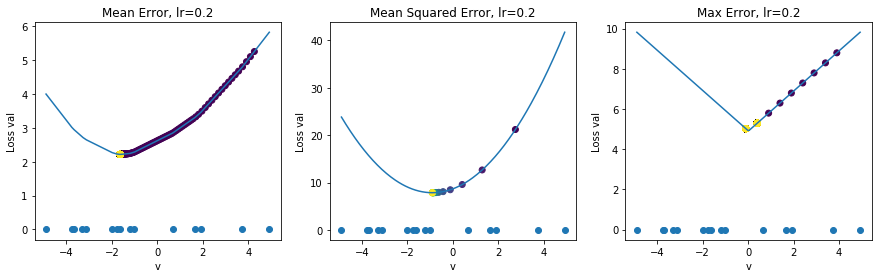

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
final_v = utils.plot_gradient_steps_1d(
    axes[0], train_set_1d, gradient_descent, me_grad, mean_error, learning_rate=0.2, num_steps=10000
)
axes[0].set_title("Mean Error, lr=0.2")
print(
    "Mean Error\tReal minimum: {:.2f}\t"
    "Minimum found by gradient descent: {:.2f}".format(
        float(minimize_me(train_set_1d)), float(final_v)
    )
)

final_v = utils.plot_gradient_steps_1d(
    axes[1],
    train_set_1d,
    gradient_descent,
    mse_grad,
    mean_squared_error,
    learning_rate=0.2,
    num_steps=10000,
)
axes[1].set_title("Mean Squared Error, lr=0.2")
print(
    "Mean Squared Error\tReal minimum: {:.2f}\t"
    "Minimum found by gradient descent: {:.2f}".format(
        float(minimize_mse(train_set_1d)), float(final_v)
    )
)

final_v = utils.plot_gradient_steps_1d(
    axes[2], train_set_1d, gradient_descent, max_grad, max_error, learning_rate=0.5, num_steps=10000
)
axes[2].set_title("Max Error, lr=0.2")
print(
    "Max Error\tReal minimum: {:.2f}\t"
    "Minimum found by gradient descent: {:.2f}".format(
        float(minimize_max(train_set_1d)), float(final_v)
    )
)

Final grad value for mean_error: [0.00428409 0.00225462]
Final grad value for mean_squared_error: [0.00231011 0.00238406]
Final grad value for max_error: [-0.91745467  0.39784033]


Text(0.5, 1.0, 'Max Error, lr=0.2')

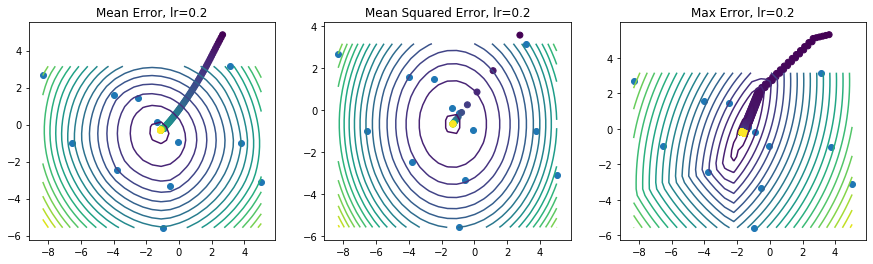

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

utils.plot_gradient_steps_2d(
    axes[0], train_set_2d, gradient_descent, me_grad, mean_error, learning_rate=0.2, num_steps=1000
)
axes[0].set_title("Mean Error, lr=0.2")
utils.plot_gradient_steps_2d(
    axes[1],
    train_set_2d,
    gradient_descent,
    mse_grad,
    mean_squared_error,
    learning_rate=0.2,
    num_steps=1000,
)
axes[1].set_title("Mean Squared Error, lr=0.2")
utils.plot_gradient_steps_2d(
    axes[2], train_set_2d, gradient_descent, max_grad, max_error, learning_rate=0.2, num_steps=1000
)
axes[2].set_title("Max Error, lr=0.2")

## Dygresje
* W literaturze anglojęzycznej można spotkać się z kilkoma różnymi określeniami na funkcję kosztu: loss function, cost function, objective function. Niektórzy stosują je zamiennie, ale inni przywiązują różne znaczenia do różnych nazw. [Tutaj szczegóły](https://stats.stackexchange.com/questions/179026/objective-function-cost-function-loss-function-are-they-the-same-thing).
* Metod wykorzystywanych do klasycznej optymalizacji funkcji jest bardzo wiele - metoda najszybszego spadku, metoda gradientów sprzężonych, różne metody wykorzystujące hesjan itd. Metoda spadku gradientu to najprostsza z nich wszystkich. Na tym kursie nie będziemy uczyć się o pozostałych metodach, jako że nie są one szczególnie popularne w metodach głębokich.